# hep-ex postdoc's affiliation an indicator of success in academia? 

In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

<img src="http://phdcomics.com/comics/archive/phd082313s.gif">

As an experimental High Energy Physics (hep-ex) grad student, I often wonder which university/national lab's postdoc would increase my odds of getting a faculty position, if I plan to stay in academia. But unlike other sub-fields in Physics, we have huge world-wide collaborations for hep-ex experiments like the Large Hadron Collider. So it is not very straightforward to conceive the contribution of a postdoc's affiliation in one's future success in getting an academic position and some might even argue that there is no such correlation. This has prompted me to put this hypothesis to test. So, let's explore whether there is indeed any correlation between a postdoc's affiliation and future success in finding an academic faculty position, in hep-ex.

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression

## Data collection

hepexrumor (https://sites.google.com/site/hepexrumor/) is a popular unofficial site which has latest rumors about the hep-ex jobs (in the US and ouside). I parse this website for getting the job rumors from 2005-2019. For this short study, I did not consider temporal variation in job patterns and combined the data of all the years.

I use the latest affiliation of a postdoc while applying for job. I only consider the postdocs who cleared the short-list round for a job as the total candidate pool, with a presumptuous assumption that postdocs not clearing the shortlist were not serious candidates for the job.

Parsing hepexrumor:

In [3]:
hepexjobsite = 'https://sites.google.com/site/hepexrumor/'
year = {2005: '2005-rumor'  ,
        2006: '2006-rumor'  ,
        2007: '2007-rumor'  ,
        2008: '2008-rumor'  ,
        2009: '2009-rumor-1',
        2010: '2009-rumor'  ,
        2011: '2011-rumors' ,
        2012: '2012-rumors' ,
        2013: '2013-rumors' ,
        2014: '2014-rumors' ,
        2015: '2015-rumors' ,
        2016: '2016-rumors' ,
        2017: '2016-2017'   ,
        2018: '2018-rumors' ,
        2019: '2019-rumors' }
df = {}
for i in range(2005,2020):
    p = pd.read_html(hepexjobsite+year[i])
    print(i, len(p))
    if (i < 2016 ):
        tUS = p[3].iloc[1:]
        tUS.columns = p[3].iloc[0]
    else:
        tnonUS = p[4].iloc[1:]
        tnonUS.columns = p[4].iloc[0]
        tnonUS = tnonUS.drop(columns=['Field'])
        tUS = p[5].iloc[1:]
        tUS.columns = p[5].iloc[0]
        tUS = tUS.drop(columns=['Field'])
        tUS.append(tnonUS, ignore_index=True)
    tUS.columns = ["Institution", "Short List", "Offers"]
    df[i] = tUS

2005 4
2006 4
2007 4
2008 4
2009 4
2010 4
2011 4
2012 4
2013 4
2014 4
2015 4
2016 6
2017 6
2018 6
2019 6


In [4]:
df[2017].head()

,Institution,Short List,Offers
1,Nebraska,Jamie Antonelli (Ohio State) [CMS] Clemens Lan...,Frank Golf (accepted)
2,Wilson Fellowship,"Joseph Zennamo (Chicago) [MicroBooNE, SBND] Mi...",Minerba Betancourt (accepted) Nhan Tran (accep...
3,Alabama,"Carl Pfendner (Ohio State) [ARA, EVA]",NaN
4,Cornell (accelerators),NaN,NaN
5,Brookhaven,John Alison (Chicago) [ATLAS] Viviana Cavalier...,Viviana Cavaliere (accepted)


## Data cleaning

There is ambiguity associated to the names of some of the universities and labs, like Fermilab is listed as 'Fermilab' in some places and 'FNAL' elsewhere. The function below removes this ambiguity by replacing the ambiguous names to a standard name for the organizations:

In [5]:
def UniNameAmbiguityFix(dfk): 
    Uni_name_ambiguity = {'Argonne': 'ANL',
                          'Boston University': 'Boston U',
                          'BU': 'Boston U',
                          'Brown University': 'Brown',
                          'Cal Tech': 'Caltech',
                          'Carnegie': 'Carnegie Mellon',
                          'Colorado State University': 'Colorado State',
                          'Fermilab': 'FNAL',
                          'FNAL/Chicago': 'FNAL',
                          'Industry/Fermilab': 'FNAL',
                          'Chicago/FNAL': 'FNAL',
                          'Göttingen': 'Gottingen',
                          'Imperial': 'Imperial College London',
                          'Indiana': 'Indiana University', 
                          'KSU': 'Kansas State',
                          'Los Alamos': 'LANL',
                          'LBL': 'LBNL',
                          'MSU': 'Michigan State', 
                          'Northeastern University': 'Northeastern',
                          'Northwestern University': 'Northwestern',
                          'OSU': 'Ohio State',
                          'SUNY Stony Brook': 'Stony Brook',
                          'Texas A&M': 'TAMU',
                          'Triumf': 'TRIUMF',
                          'U Chicago': 'UChicago',
                          'Chicago': 'UChicago',
                          'University of Chicago': 'UChicago',
                          'Berkeley': 'UC Berkeley',
                          'University of Colorado Boulder': 'UC Boulder',
                          'CU Boulder': 'UC Boulder',
                          'Colorado': 'UC Boulder',
                          'Davis': 'UC Davis',
                          'Irvine': 'UC Irvine',
                          'UCSD': 'UC San Diego',
                          'UCSB': 'UC Santa Barbara',
                          'UCSC': 'UC Santa Cruz',
                          'UIC': 'University of Illinois Chicago',
                          'University of Illinois Urbana-Champaign': 'UIUC',
                          'University of North Carolina': 'UNC',
                          'University of Pennsylvania': 'UPenn',
                          'University of Texas Austin': 'UT Austin', 
                          'Florida': 'University of Florida',
                          'Geneva': 'University of Geneva',
                          'Hawaii': 'University of Hawaii',
                          'Maryland': 'University of Maryland', 
                          'Michigan': 'University of Michigan',
                          'Minnesota': 'University of Minnesota',
                          'Sheffield': 'University of Sheffield',
                          'Victoria': 'University of Victoria',
                          'Virginia': 'University of Virginia',
                          'Washington': 'University of Washington',
                          'University of Wisconsin Madison': 'UW Madison',
                          'Wisconsin': 'UW Madison',
                          'UW': 'UW Madison',
                          'UW-Madison': 'UW Madison'}
    Uni_name_ambiguity.keys()
    dfk = dfk.replace({'Affiliation': Uni_name_ambiguity})
    dfk = dfk.groupby(['Applicant', 'Affiliation'])['Attempts'].sum().reset_index()
    return dfk

### Applicant stats

Extracting tables for applicant job performance (along with their latest affiliation at the time of job application) from tables for job results.

In [6]:
ApplicantTable = {}
for i in range(2005, 2020):
    attempt = df[i]['Short List'].str.split("\)", expand=True)
    attempt = attempt.unstack()
    attempt = attempt.str.split(r"\[.*?\]").str.join('')
    attempt = attempt.str.strip()
    attempt = attempt.value_counts()
    attempt = attempt.to_frame()
    attempt.reset_index(level=0, inplace=True)
    attempt.columns = ['Applicant', 'Attempts']
    attemptTable = attempt['Applicant'].str.split('(', expand=True)
    attemptTable.columns = ['Applicant', 'Affiliation']
    attemptTable['Attempts'] = attempt['Attempts']
    attemptTable = attemptTable.iloc[1:]
    indexDrop = attemptTable[attemptTable['Applicant'].str.contains("\)" or "\(" or "[" or "]")].index
    attemptTable.drop(indexDrop , inplace=True)
    attemptTable.Affiliation.str.strip()
    attemptTable = UniNameAmbiguityFix(attemptTable)

    offerTable = df[i]['Offers'].str.split(r"\(.*?\)", expand=True)
    offerTable = offerTable.unstack()
    offerTable = offerTable.str.strip()
    offerTable = offerTable.value_counts()
    offerTable = offerTable.to_frame()
    offerTable.reset_index(level=0, inplace=True)
    offerTable.columns = ['Applicant', 'Offers']
    offerTable['Applicant'] = offerTable['Applicant'].str.replace(u'† \xa0', u'')
    offerTable = offerTable.iloc[1:]

    attemptTable.Applicant = attemptTable.Applicant.str.strip()
    offerTable.Applicant   = offerTable.Applicant.str.strip()

    ApplicantTable[i] = attemptTable.merge(offerTable, how='left', left_on='Applicant', right_on='Applicant')
    ApplicantTable[i] = ApplicantTable[i].fillna(0)
    ApplicantTable[i].Offers = ApplicantTable[i].Offers.astype(int)
    #applicants with no affiliations listed are dropped
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Affiliation'].str.strip() == ""].index , inplace=True)
    #blank applicant dropped
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Applicant'].str.strip() == ""].index , inplace=True)
    #theory or non-hep jobs to be dropped
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Applicant'].str.lower().str.contains('theory')].index , inplace=True)
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Applicant'].str.lower().str.contains('hep')].index , inplace=True)
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Affiliation'] == 'IAS'].index , inplace=True)
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Affiliation'] == 'theory'].index , inplace=True)
    #other misc. cleaning
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Affiliation'] == 'notes below'].index , inplace=True)
    ApplicantTable[i].drop(ApplicantTable[i][ApplicantTable[i]['Affiliation'] == 'Ultralytics'].index , inplace=True)
    
    ApplicantTable[i] = ApplicantTable[i].sort_values(by=['Offers', 'Attempts'], ascending=False)
    ApplicantTable[i]

In [7]:
ApplicantTable[2015].head()

,Applicant,Affiliation,Attempts,Offers
67,Joshua Spitz,MIT,7,2
5,Alex Himmel,Duke,5,2
77,Laura Fields,Northwestern,4,2
90,Matt Wetstein,UChicago,4,2
12,Andrzej Szelc,Yale,2,2


Combining data of all the years. I define a success as getting at least one job offer, ie assign an applicant success = 1. With no offers at all, I define the (short-listed) candidate to be unsuccessful, ie assign the applicant success = 0.

In [8]:
ApplicantTableAllYears = pd.concat(ApplicantTable, ignore_index=True)
ApplicantTableAllYears = ApplicantTableAllYears.groupby(['Applicant', 'Affiliation'])['Attempts', 'Offers'].sum().reset_index()
ApplicantTableAllYears = ApplicantTableAllYears.sort_values(by=['Offers', 'Attempts'], ascending=False)
ApplicantTableAllYears['Success'] = (ApplicantTableAllYears['Offers'] > 0).astype(int)
ApplicantTableAllYears

,Applicant,Affiliation,Attempts,Offers,Success
219,Florencia Canelli,FNAL,15,7,1
570,Sabine Lammers,Columbia,7,5,1
85,Ben Kilminster,Ohio State,8,4,1
114,Carter Hall,SLAC,5,4,1
214,Eva Halkiadakis,Rochester,9,3,1
...,...,...,...,...,...
678,Yoshikazu Nagai,UC Boulder,1,0,0
683,Yusuke Koshio,University of Tokyo,1,0,0
685,Zarko Pavlovic,LANL,1,0,0
687,Zeynep Demeragli,MIT,1,0,0


### How to rank University/lab (employing postdocs) in terms of their postdocs success?

To assess the average quality of postdocs in an organization (affiliation), I add a Offers/candidate metric. Total offers also give an estimate of the success of the affiliation. I use these two university metrics to rank the universities/labs to produce successful candidates affiliated to them (first priority given to Total Offers, and then to Offers/candidate).

In [9]:
UniversityTableAllYears = ApplicantTableAllYears.drop(columns=['Applicant', 'Attempts'])
UniversityTableAllYears['Failure'] = (UniversityTableAllYears['Offers'] == 0).astype(int)
UniversityTableAllYears = UniversityTableAllYears.groupby(['Affiliation'])['Offers', 'Success', 'Failure'].sum().reset_index()
UniversityTableAllYears['Offers/candidate'] = UniversityTableAllYears['Offers']*1./(UniversityTableAllYears['Success'] + UniversityTableAllYears['Failure'])
UniversityTableAllYears.columns = ['Affiliation', 'Total Offers', 'Total successful candidates', 'Total unsuccessful candidates', 'Offers/candidate']
UniversityTableAllYears = UniversityTableAllYears.sort_values(by=['Total successful candidates', 'Offers/candidate'], ascending=False)
UniversityTableAllYears['Rank'] = np.arange(1,150)
UniversityTableAllYears

,Affiliation,Total Offers,Total successful candidates,Total unsuccessful candidates,Offers/candidate,Rank
32,FNAL,58,39,26,0.892308,1
56,LBNL,23,20,12,0.718750,2
120,UChicago,25,17,10,0.925926,3
15,CERN,16,15,29,0.363636,4
24,Columbia,19,12,3,1.266667,5
...,...,...,...,...,...,...
138,University of Sussex,0,0,1,0.000000,145
139,University of Tokyo,0,0,1,0.000000,146
140,University of Victoria,0,0,2,0.000000,147
145,Western Illinois,0,0,1,0.000000,148


Candidates with at least one offer are counted as successful, while ones with no offer are counted as unsuccessful candidates.

## Data visualization

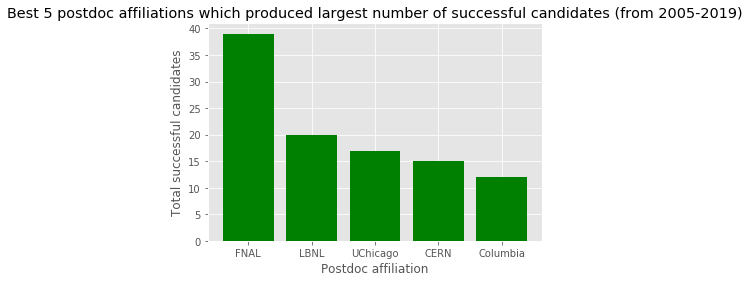

In [10]:
plt.style.use('ggplot')
x_pos = [i for i, _ in enumerate(UniversityTableAllYears['Affiliation'].iloc[:5])]

plt.bar(x_pos, UniversityTableAllYears['Total successful candidates'].iloc[:5], color='green')
plt.xlabel("Postdoc affiliation")
plt.ylabel("Total successful candidates")
plt.title("Best 5 postdoc affiliations which produced largest number of successful candidates (from 2005-2019)")

plt.xticks(x_pos, UniversityTableAllYears['Affiliation'].iloc[:5])

plt.show()

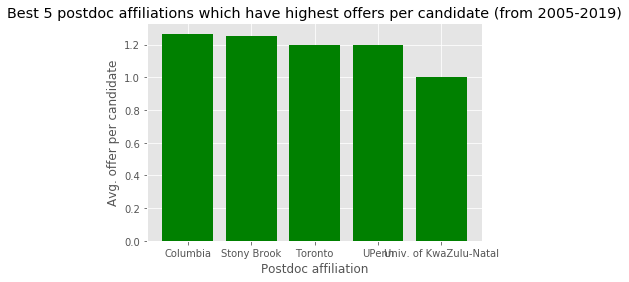

In [11]:
UniversityTableAllYearsBestOfferRate = UniversityTableAllYears.sort_values(by=['Offers/candidate'], ascending=False)

plt.style.use('ggplot')
x_pos = [i for i, _ in enumerate(UniversityTableAllYearsBestOfferRate['Affiliation'].iloc[:5])]

plt.bar(x_pos, UniversityTableAllYearsBestOfferRate['Offers/candidate'].iloc[:5], color='green')
plt.xlabel("Postdoc affiliation")
plt.ylabel("Avg. offer per candidate")
plt.title("Best 5 postdoc affiliations which have highest offers per candidate (from 2005-2019)")

plt.xticks(x_pos, UniversityTableAllYearsBestOfferRate['Affiliation'].iloc[:5])

plt.show()

## Success of postdocs w.r.t their affiliation's (university/lab's) metrics

In addition to the binary metric of at least one offer as success, I add another candidate metric - Success odds. Success odds = (total offers)/(total attempts - total offers) for a candidate. The correlation between candidate metrics and university/lab (affiliation) metrics is of interest, as it gives an intuition about the spead of department's success metrics over its postdocs. Are there some good/bad postdocs who skew their affiliation's (university's) success metric or are all the postdocs in general doing similarly from that university in academic job hunting.

In [12]:
ApplicantTableAllYearRanked = ApplicantTableAllYears.merge(UniversityTableAllYears[['Affiliation', 'Rank', 'Offers/candidate', 'Total successful candidates', 'Total unsuccessful candidates']], how='left', left_on='Affiliation', right_on='Affiliation')
ApplicantTableAllYearRanked.rename(columns={'Rank':'Affiliation rank'}, inplace=True)
ApplicantTableAllYearRanked['Success odds'] = ApplicantTableAllYearRanked['Offers']/(ApplicantTableAllYearRanked['Attempts'] - ApplicantTableAllYearRanked['Offers'])
ApplicantTableAllYearRanked

,Applicant,Affiliation,Attempts,Offers,Success,Affiliation rank,Offers/candidate,Total successful candidates,Total unsuccessful candidates,Success odds
0,Florencia Canelli,FNAL,15,7,1,1,0.892308,39,26,0.875
1,Sabine Lammers,Columbia,7,5,1,5,1.266667,12,3,2.500
2,Ben Kilminster,Ohio State,8,4,1,19,0.900000,4,6,1.000
3,Carter Hall,SLAC,5,4,1,7,0.888889,9,9,4.000
4,Eva Halkiadakis,Rochester,9,3,1,20,0.857143,4,3,0.500
...,...,...,...,...,...,...,...,...,...,...
688,Yoshikazu Nagai,UC Boulder,1,0,0,34,0.500000,3,3,0.000
689,Yusuke Koshio,University of Tokyo,1,0,0,146,0.000000,0,1,0.000
690,Zarko Pavlovic,LANL,1,0,0,22,0.666667,4,2,0.000
691,Zeynep Demeragli,MIT,1,0,0,6,0.608696,12,11,0.000


## Success odds vs. Affiliation metric

Pearson correlation: 

In [13]:
correlation = ApplicantTableAllYearRanked[['Offers/candidate' ,'Total successful candidates', 'Affiliation rank', 'Success odds']]
correlation.corr()

,Offers/candidate,Total successful candidates,Affiliation rank,Success odds
Offers/candidate,1.000000,0.414271,-0.686715,0.341810
Total successful candidates,0.414271,1.000000,-0.588940,0.159448
Affiliation rank,-0.686715,-0.588940,1.000000,-0.235494
Success odds,0.341810,0.159448,-0.235494,1.000000


Offer/candidate has a higher correlation with success odds.

In [14]:
#Support Vector Regression
from sklearn.svm import SVR, LinearSVR

In [15]:
Y = np.array(ApplicantTableAllYearRanked['Success odds'].astype(float))
Y = np.nan_to_num(Y)

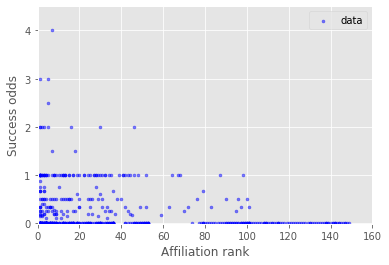

In [16]:
plt.scatter(ApplicantTableAllYearRanked['Affiliation rank'], ApplicantTableAllYearRanked['Success odds'], alpha=0.5, color='blue', marker='.', label='data')
plt.xlabel('Affiliation rank')
plt.ylabel('Success odds')
plt.xlim([-0.01,160])
plt.ylim([-0.01,4.5])
plt.legend()
plt.show()

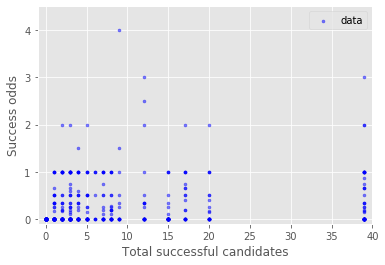

In [17]:
plt.scatter(ApplicantTableAllYearRanked['Total successful candidates'], ApplicantTableAllYearRanked['Success odds'], alpha=0.5, color='blue', marker='.', label='data')
plt.xlabel('Total successful candidates')
plt.ylabel('Success odds')
plt.xlim([-1,40])
plt.ylim([-0.1,4.5])
plt.legend()
plt.show()

/home/sourav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


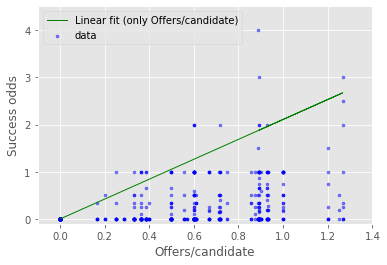

In [18]:
plt.scatter(ApplicantTableAllYearRanked['Offers/candidate'], ApplicantTableAllYearRanked['Success odds'], alpha=0.5, color='blue', marker='.', label='data')
plt.xlabel('Offers/candidate')
plt.ylabel('Success odds')
plt.xlim([-0.1,1.4])
plt.ylim([-0.1,4.5])

X = np.array(ApplicantTableAllYearRanked[['Offers/candidate']].astype(float))
X = np.nan_to_num(X)

Z = np.array(ApplicantTableAllYearRanked[['Offers/candidate', 'Total successful candidates']].astype(float))


svr_linOfferDensity = LinearSVR(random_state=0, tol=1e-5)
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

Y_svrlinOfferDensity = svr_linOfferDensity.fit(X, Y).predict(X)
#Y_rbf = svr_rbf.fit(Z, Y).predict(Z)

plt.plot(X, Y_svrlinOfferDensity, color='green', lw=1, label='Linear fit (only Offers/candidate)')
#plt.plot(X, Y_rbf, color='black', lw=1, label='rbf model')
plt.legend()
plt.show()

## Success vs. Affiliation metric

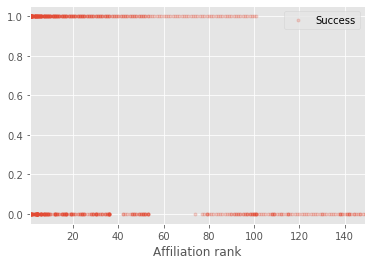

In [19]:
ApplicantTableAllYearRanked.plot(x='Affiliation rank', y='Success', style='.', alpha = 0.2)

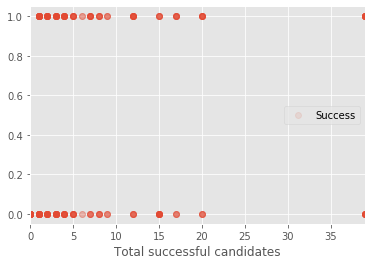

In [20]:
ApplicantTableAllYearRanked.plot(x='Total successful candidates', y='Success', style='o', alpha = 0.1)

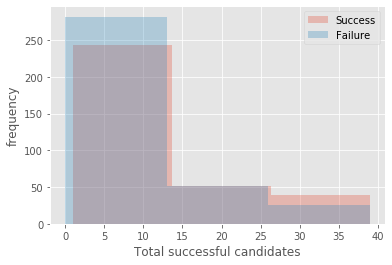

In [21]:
t = ApplicantTableAllYearRanked[['Total successful candidates', 'Success']]
t = t.sort_values(by=['Total successful candidates'], ascending=False)
tsuccess = t[t['Success'] == 1]
tfailure = t[t['Success'] == 0]

bins=3
plt.hist(tsuccess['Total successful candidates'], bins, alpha=0.3, label='Success')
plt.hist(tfailure['Total successful candidates'], bins, alpha=0.3, label='Failure')

plt.xlabel('Total successful candidates')
plt.ylabel('frequency')
plt.legend(loc='best')
plt.show()

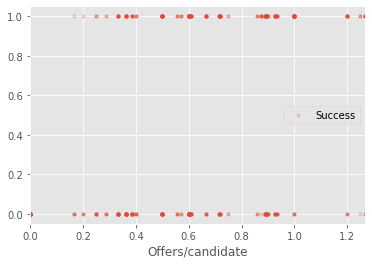

In [22]:
ApplicantTableAllYearRanked.plot(x='Offers/candidate', y='Success', style='.', alpha = 0.2)

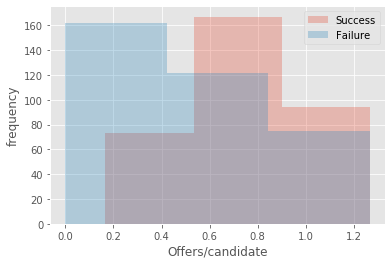

In [23]:
t = ApplicantTableAllYearRanked[['Offers/candidate', 'Success']]
t = t.sort_values(by=['Offers/candidate'], ascending=False)
tsuccess = t[t['Success'] == 1]
tfailure = t[t['Success'] == 0]

bins=3
plt.hist(tsuccess['Offers/candidate'], bins, alpha=0.3, label='Success')
plt.hist(tfailure['Offers/candidate'], bins, alpha=0.3, label='Failure')

plt.xlabel('Offers/candidate')
plt.ylabel('frequency')
plt.legend(loc='best')
plt.show()

Offer/candidate has a fair discriminating power between success and failure cases.

In [24]:
logisticRegr = LogisticRegression()
logisticRegr.fit(ApplicantTableAllYearRanked[['Affiliation rank']], ApplicantTableAllYearRanked['Success'])
logisticRegr.score(ApplicantTableAllYearRanked[['Affiliation rank']], ApplicantTableAllYearRanked['Success'])

/home/sourav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5844155844155844

In [25]:
logisticRegr = LogisticRegression()
logisticRegr.fit(ApplicantTableAllYearRanked[['Affiliation rank', 'Offers/candidate', 'Total successful candidates']], ApplicantTableAllYearRanked['Success'])
logisticRegr.score(ApplicantTableAllYearRanked[['Affiliation rank', 'Offers/candidate', 'Total successful candidates']], ApplicantTableAllYearRanked['Success'])

/home/sourav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6536796536796536

In [26]:
logisticRegr = LogisticRegression()
logisticRegr.fit(ApplicantTableAllYearRanked[['Total successful candidates']], ApplicantTableAllYearRanked['Success'])
logisticRegr.score(ApplicantTableAllYearRanked[['Total successful candidates']], ApplicantTableAllYearRanked['Success'])

/home/sourav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5526695526695526

In [27]:
logisticRegr = LogisticRegression()
logisticRegr.fit(ApplicantTableAllYearRanked[['Total successful candidates', 'Offers/candidate']], ApplicantTableAllYearRanked['Success'])
logisticRegr.score(ApplicantTableAllYearRanked[['Total successful candidates', 'Offers/candidate']], ApplicantTableAllYearRanked['Success'])

/home/sourav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6551226551226551

In [28]:
logisticRegr = LogisticRegression()
logisticRegr.fit(ApplicantTableAllYearRanked[['Offers/candidate']], ApplicantTableAllYearRanked['Success'])
logisticRegr.score(ApplicantTableAllYearRanked[['Offers/candidate']], ApplicantTableAllYearRanked['Success'])

/home/sourav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6551226551226551

'Total successful candidates' metric does not provide any additional discriminating power than 'Offers/candidate' metric. 

To get an intuition of why 'Offers/candidate' metric is a good indicator of postdoc success, let's look at the actual distribution of number of offer of a hep-ex postdoc:

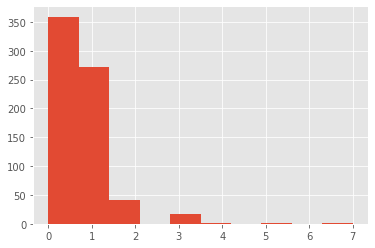

In [29]:
ApplicantTableAllYearRanked['Offers'].hist(bins=10)

Since most postdocs in hep-ex typically do not receive more than 1 offer, 'Offers/candidate' (ie the avg. number of offers by a postdoc from a given afiliation (university/lab), actually represents the number of successful postdocs of that affiliation.

## Summary
* Hence, 'Offers/candidate' is the best metric to indicate if a university/lab produces successful postdocs.
* According to 'Offers/candidate' metric Columbia University is the best university to do a hep-ex postdoc.

# Next steps

* temporal variations in hep-ex job market not taken into account
* US and non-US jobs to be treated separately
* should separate the study into energy, intensity and cosmic frontiers, as the job trends and funding are different for each
* think of other metrics